<a href="https://colab.research.google.com/github/GeorgeWilliam1999/XAI-Project/blob/main/Quantum_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qulacs
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [2]:
import qulacs
import numpy as np
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd 

# QML
## Parameterised quantum circuit set up

The goal here is to recreate a circuit from Dominics thesis,

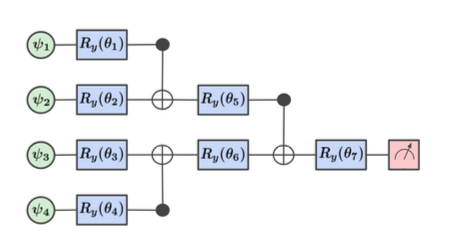

This circuit is able to perform binary classification of data.

## Iris data processing

In [3]:
#Load and view iris data set
iris = load_iris()
iris.DESCR

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

In [4]:
iris.data.shape,iris.target.shape

((150, 4), (150,))

In [5]:
#Load iris data and classification to the same array.
features = iris.feature_names
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target

In [6]:
features

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

In [8]:
colors = {0:'red', 1:'green', 2:'blue'}

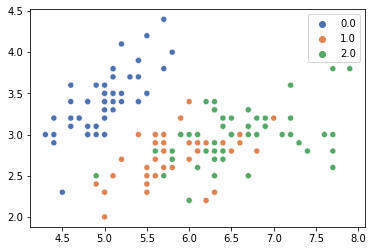

In [9]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

## Data preprocessing and embedding

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100, 4), (50, 4), (100,), (50,))

The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.

Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.

To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.

But first, the data will need normalising as described above.

Test train split

In [135]:
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  min_values = np.zeros(dim)
  for i in range(dim):
    min_values[i] = np.amin(data[:,i])
    data[:,i] = data[:,i] - min_values[i]
  print(min_values)


  largest_values = np.zeros(dim)
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])
  print(largest_values)

  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))

  for i in range(dim):

    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

In [136]:
normed_train_data = half_pi_norm(X_train)
normed_test_data = half_pi_norm(X_test)

[0. 0. 0. 0.]
[3.4 2.2 5.6 2.4]
[0. 0. 0. 0.]
[3.5 2.2 5.9 2.4]


## Trinary Clasification

### Embedding circuit

Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

In [137]:
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

### Computational Circuit 

To build two qubit gates one needs to use combinations of single qubit gates and control operations.

I am copy the state after each operation for comparison.

Now its time for a parameterised quantum circuit.

Each two qubit unitary will be specified by two angles

In [138]:
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

In [139]:
from qulacs import Observable

In [140]:
circuit = U()
circuit.get_parameter_count()

7

In [141]:
theta_0 = np.random.rand(7)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

In [142]:
circuit.get_parameter

<bound method PyCapsule.get_parameter of *** Quantum Circuit Info ***
# of qubit: 4
# of step : 5
# of gate : 10
# of 1 qubit gate: 7
# of 2 qubit gate: 3
Clifford  : no
Gaussian  : no

*** Parameter Info ***
# of parameter: 7
>

In [143]:
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

In [144]:
param

[0.03606934876024148,
 0.913994219261015,
 0.24458923753552664,
 0.18482421355215017,
 0.5392135681518272,
 0.9105865166333127,
 0.07378122812421006]

NOTE TO SELF

use pca on the components to see what the most important eigen vlaues/vectors are doing.

In [145]:
#Update |0000...00> to embedded values
state_1 = pointwise_qubit_embedding(normed_train_data[0])
state_1.get_vector()

array([ 0.75383182+0.j, -0.25265896+0.j, -0.25089932+0.j,  0.08409298+0.j,
       -0.35008844+0.j,  0.11733782+0.j,  0.11652062+0.j, -0.03905378+0.j,
       -0.31224736+0.j,  0.10465477+0.j,  0.1039259 +0.j, -0.03483245+0.j,
        0.14501138+0.j, -0.04860292+0.j, -0.04826442+0.j,  0.0161766 +0.j])

In [146]:
state_2 = state_1
circuit.update_quantum_state(state_2)
state_2.get_vector()

array([ 0.36552566+0.3359867j ,  0.128058  +0.11770934j,
        0.21344509-0.20839571j,  0.07693297-0.075113j  ,
       -0.32213487+0.04557858j, -0.1128565 +0.01596797j,
       -0.49640597-0.08407892j, -0.17892184-0.03030494j,
        0.11412172+0.111422j  ,  0.03998132+0.0390355j ,
        0.18996015-0.17460904j,  0.06846819-0.06293512j,
       -0.26541114+0.0449541j , -0.09298395+0.01574919j,
       -0.16741038-0.02368675j, -0.06034048-0.00853752j])

### define operator: Pauli Z:

In [147]:
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

In [148]:
pred = z.get_expectation_value(state_2)

In [149]:
pred

(0.011018310917057822+0j)

In [150]:
def pred(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)

  '''if exp >= 0.33:
    pred = 2
  elif exp < 0.33 and exp > -0.33:
    pred = 1
  else:
    pred = 0'''

  return exp + 1

In [151]:
#Classify and expectation value that is reshaped to be between 0 and 2.
def classi(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

Below I visualise the naive predictions on the training data. Clearly the predictions are sub optimal.

In [ ]:
predictions = []
for i in range(len(normed_train_data)):
  predictions.append(pred(normed_train_data[i],U,np.random.rand(7)))
predictions

Actual classes.

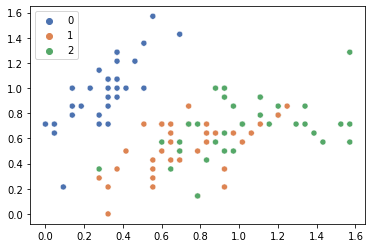

In [153]:
sns.scatterplot(data=normed_train_data, x=normed_train_data[:,0], y=normed_train_data[:,1], hue=y_train, palette="deep")

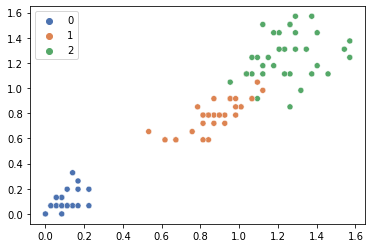

In [171]:
sns.scatterplot(data=normed_train_data, x=normed_train_data[:,2], y=normed_train_data[:,3], hue=y_train, palette="deep")

Naive expectation values with random angle, very poor but thats expected.

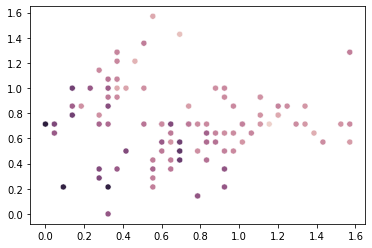

In [154]:
sns.scatterplot(data=normed_train_data, x=normed_train_data[:,0], y=normed_train_data[:,1], hue=predictions, legend = False)

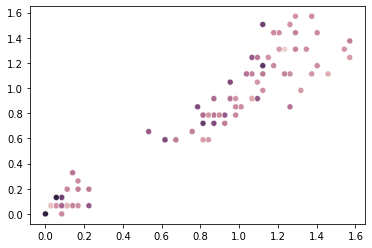

In [170]:
sns.scatterplot(data=normed_train_data, x=normed_train_data[:,2], y=normed_train_data[:,3], hue=predictions, legend = False)

In [155]:
def cost_train(theta):
  #get predictions
  predictions = np.zeros(y_train.shape[0])
  for i in range(normed_train_data.shape[0]):
    predictions[i] = pred(normed_train_data[i],U, theta)
  #Simple MSE example
  
  #predictions are currently expectation values
  L = ((predictions - y_train)**2).mean()

  return L

In [156]:
cost_train(np.random.rand(7))

0.9975845516028105

In [157]:
#find number of correct predictions
correct = 0
for i in range(len(y_train)):
  if y_train[i] == classi(predictions[i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')


The initial calssification is 33.0 % accurate


### Optimise

In [158]:
from scipy.optimize import minimize #BFGS works well/cobyla

In [159]:
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(7)
result = minimize(cost_train, theta_0, method='cobyla')
theta = result.x

In [160]:
theta, theta_0

(array([0.89710335, 2.2246629 , 0.88691549, 0.5453582 , 0.4714406 ,
        0.24921038, 0.63010268]),
 array([0.58610789, 0.9566405 , 0.88578156, 0.51033814, 0.61532817,
        0.35337289, 0.73386712]))

In [161]:
cost_train(theta)

0.3310802008221108

Reclasify

In [162]:
def cost_test(theta):
  #get predictions
  predictions = np.zeros(normed_test_data.shape[0])
  for i in range(normed_test_data.shape[0]):
    predictions[i] = pred(normed_test_data[i],U,theta)
  #Simple MSE example
  L = ((predictions - y_test)**2).mean()
  return L

In [163]:
cost_test(theta)

0.35201834588573233

In [179]:
better_predictions = np.zeros(normed_test_data.shape[0])
expectations = np.zeros(normed_test_data.shape[0])
for i in range(normed_test_data.shape[0]):
  better_predictions[i] = classi(pred(normed_test_data[i],U, theta))
  expectations[i] = pred(normed_test_data[i],U, theta)
  


In [210]:
better_predictions - y_test

array([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.])

### Prediction graphs

Text(0.5, 1.0, 'features 1 & 2  predictions')

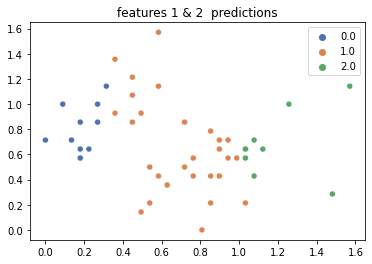

In [192]:
sns.scatterplot(data=normed_test_data, x=normed_test_data[:,0], y=normed_test_data[:,1], hue=better_predictions, palette="deep").set_title('Features 1 & 2  predictions')

Text(0.5, 1.0, 'Feature 3 & 4 predictions')

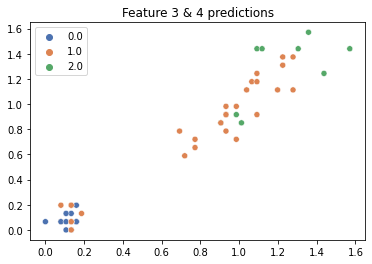

In [195]:
sns.scatterplot(data=normed_test_data, x=normed_test_data[:,2], y=normed_test_data[:,3], hue=better_predictions, palette="deep").set_title('Feature 3 & 4 predictions')

### Expectation graphs

Text(0.5, 1.0, 'Features 1 & 2 expectaions')

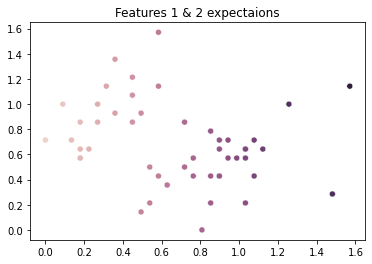

In [196]:
sns.scatterplot(data=normed_test_data, x=normed_test_data[:,0], y=normed_test_data[:,1], hue=expectations, legend = False).set_title('Features 1 & 2 expectaions')

Text(0.5, 1.0, 'Feature 1 & 2 expectations')

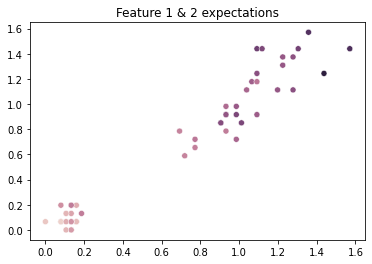

In [193]:
sns.scatterplot(data=normed_test_data, x=normed_test_data[:,2], y=normed_test_data[:,3], hue=expectations, legend = False).set_title('Feature 1 & 2 expectations')

### True graphs

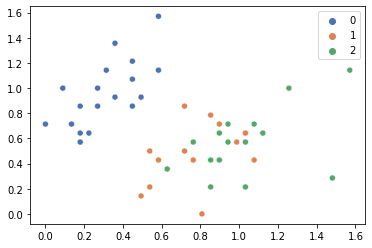

In [174]:
sns.scatterplot(data=normed_test_data, x=normed_test_data[:,0], y=normed_test_data[:,1], hue=y_test, palette="deep")

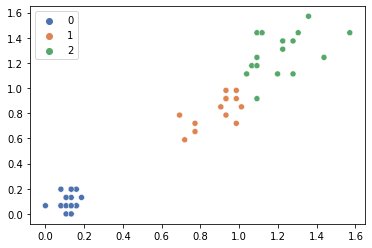

In [176]:
sns.scatterplot(data=normed_test_data, x=normed_test_data[:,2], y=normed_test_data[:,3], hue=y_test, palette="deep")

In [167]:
#find number of correct predictions
correct = 0
for i in range(len(y_test)):
  if y_test[i] == classi(better_predictions[i]):
    correct += 1

print('The initial calssification is',(correct/len(y_test)) * 100, '% accurate')

The initial calssification is 57.99999999999999 % accurate


# Binary Classification 

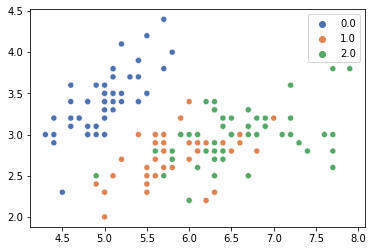

In [197]:
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

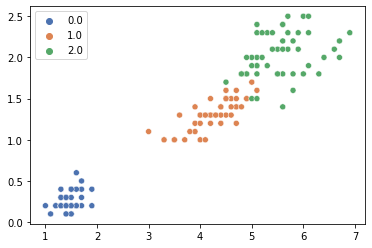

In [198]:
sns.scatterplot(data=data, x=data[:,2], y=data[:,3], hue=data[:,4], palette="deep")

## Convert and visualise data

The embedding and computational circuits will be unchanged.

In [204]:
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(y_test)):
  if y_test[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train)):
  if y_train[i] == 2:
    y_train_bi[i] = 1


In [205]:
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

[0. 0. 0. 0.]
[3.4 2.2 5.6 2.4]
[0. 0. 0. 0.]
[3.5 2.2 5.9 2.4]


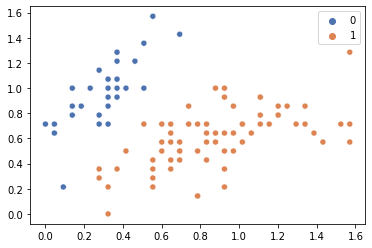

In [206]:
sns.scatterplot(data=normed_train_data_bi, x=normed_train_data_bi[:,0], y=normed_train_data_bi[:,1], hue=y_train_bi, palette="deep")

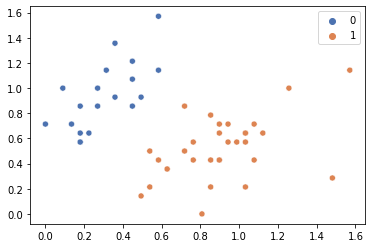

In [209]:
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")